In [2]:
!pip3 install pathlib
!pip3 install numpy
!pip3 install pandas
!pip3 install multiprocess
!pip3 install matplotlib
!pip3 install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import multiprocess as mp
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data: Huge data using multi-thread processing technique

In [4]:
path = Path("../data/")
out_path = str(path / "endomondoHR_proper.json")

def process(line):
    return eval(line)

pool = mp.Pool(5) 
with open(out_path, 'r') as f:
    data = pool.map(process, f)
pool.close()
pool.join()

In [6]:
# We will not focus on longitude, latitude, and url in our research questions
df = pd.DataFrame(data)
df = df.dropna().drop(['longitude', 'latitude', 'url'], axis=1)
df.head()

,longitude,altitude,latitude,sport,id,heart_rate,gender,timestamp,url,userId,speed
0,"[24.64977040886879, 24.65014273300767, 24.6509...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....","[60.173348765820265, 60.173239801079035, 60.17...",bike,396826535,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",male,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,"[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3..."
1,"[24.649855233728886, 24.65015547350049, 24.650...","[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....","[60.173247596248984, 60.17320962622762, 60.172...",bike,392337038,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",male,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,"[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30..."
2,"[24.64995657093823, 24.650197718292475, 24.651...","[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....","[60.17326201312244, 60.173205351457, 60.172969...",bike,389643739,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",male,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,"[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3..."
3,"[24.649874344468117, 24.650242729112506, 24.65...","[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....","[60.173286236822605, 60.17323946580291, 60.173...",bike,386729739,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",male,"[1407432042, 1407432048, 1407432056, 140743206...",https://www.endomondo.com/users/10921915/worko...,10921915,"[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3..."
6,"[24.64981692843139, 24.649868477135897, 24.650...","[24.0, 24.0, 24.0, 21.0, 18.6, 17.4, 17.4, 17....","[60.17327919602394, 60.17327232286334, 60.1732...",bike (transport),381185226,"[118, 118, 119, 120, 122, 124, 126, 129, 133, ...",male,"[1406647079, 1406647080, 1406647082, 140664708...",https://www.endomondo.com/users/10921915/worko...,10921915,"[7.218, 9.8208, 14.3532, 16.2972, 20.1276, 20...."


## Create boxplot to describe the heart rate performance for each type of sport, help with the recommendation

In [18]:
def generate_sport_heart_rate_df(sport_type):
    '''
    Since values in original dataframe are stored in list, we can create individual dataframes for each sport type
    to record the heart rate for plotting purpose
    '''
    heart_rate_dict = {}
    for index, row in df.iterrows():
        if row['sport'] == sport_type:
            if sport_type not in heart_rate_dict:
                heart_rate_dict[sport_type] = []
            heart_rate_dict[sport_type].extend(row['heart_rate'])

    df_heart_rate_by_type = pd.DataFrame.from_dict(heart_rate_dict).rename(columns={sport_type:'heart rate'})
    df_heart_rate_by_type['type'] = sport_type
    return df_heart_rate_by_type

In [19]:
sport_type_dfs = []
sport_types = df['sport'].unique()
display(sport_types)
for sport in sport_types:
    sport_type_dfs.append(generate_sport_heart_rate_df(sport))

array(['bike', 'bike (transport)', 'run', 'kayaking', 'indoor cycling',
       'mountain bike', 'orienteering', 'core stability training', 'walk',
       'cross-country skiing', 'fitness walking', 'roller skiing',
       'skate', 'hiking', 'horseback riding'], dtype=object)

/var/folders/t2/t_vlyyqs1fx_lsym71tgvwpm0000gn/T/ipykernel_7307/3170569379.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


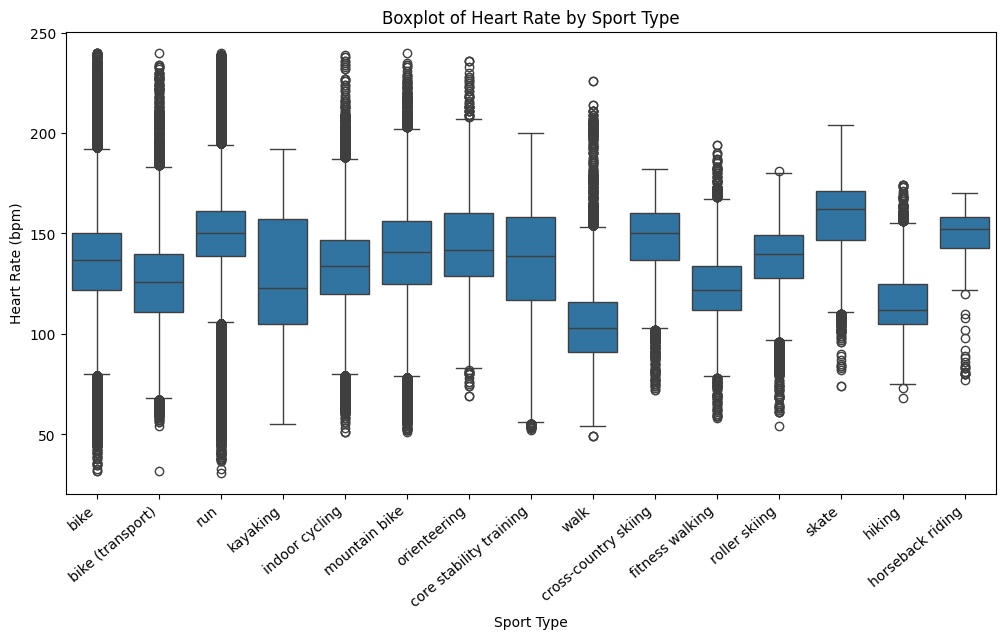

In [10]:
df_sport_heart_rate = pd.concat(sport_type_dfs)
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=df_sport_heart_rate, x='type', y='heart rate')
ax.set_xlabel('Sport Type')
ax.set_ylabel('Heart Rate (bpm)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Boxplot of Heart Rate by Sport Type')
plt.show()

## Create 15 plots for each sport(timestamp VS speed, timestamp vs heart_rate) to visualize the change pattern

In [11]:
df.columns

Index(['altitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp',
       'userId', 'speed'],
      dtype='object')

In [12]:
df['sport'].unique()

array(['bike', 'bike (transport)', 'run', 'kayaking', 'indoor cycling',
       'mountain bike', 'orienteering', 'core stability training', 'walk',
       'cross-country skiing', 'fitness walking', 'roller skiing',
       'skate', 'hiking', 'horseback riding'], dtype=object)

## Example graph with Kayaking only, will later extend to all sports

In [13]:
filtered_df = df[df['sport'] == 'kayaking']

# Select the first row of the filtered dataframe
first_row = filtered_df.iloc[0]

# Create a new dataframe from the first row
new_df = pd.DataFrame([first_row])
new_df = new_df[['timestamp', 'heart_rate', 'speed']]

# Explode the dataframe
exploded_df = new_df.explode('timestamp').reset_index(drop=True)
exploded_df['heart_rate'] = new_df['heart_rate'].explode().reset_index(drop=True)
exploded_df['speed'] = new_df['speed'].explode().reset_index(drop=True)


# Convert timestamp to datetime format
exploded_df['timestamp'] = pd.to_datetime(exploded_df['timestamp'], unit='s')

# Calculate the difference between consecutive rows in the timestamp column
exploded_df['time_diff'] = exploded_df['timestamp'].diff().dt.total_seconds()

time_diff_threshold = 20
while True:
    # Filter rows based on the current time_diff_threshold
    filtered_df = exploded_df[(exploded_df['time_diff'] >= time_diff_threshold) | (exploded_df['time_diff'].isna())]
    
    # If the length of the resulting dataframe is at least 100 rows or the threshold has reached 0, break out of the loop
    if len(filtered_df) >= 100 or time_diff_threshold <= 0:
        break
    
    # Decrease the time_diff_threshold by 1 second
    time_diff_threshold -= 1

# Drop the 'time_diff' column
filtered_df = filtered_df.drop(columns=['time_diff'])


In [14]:
filtered_df.shape

(233, 3)

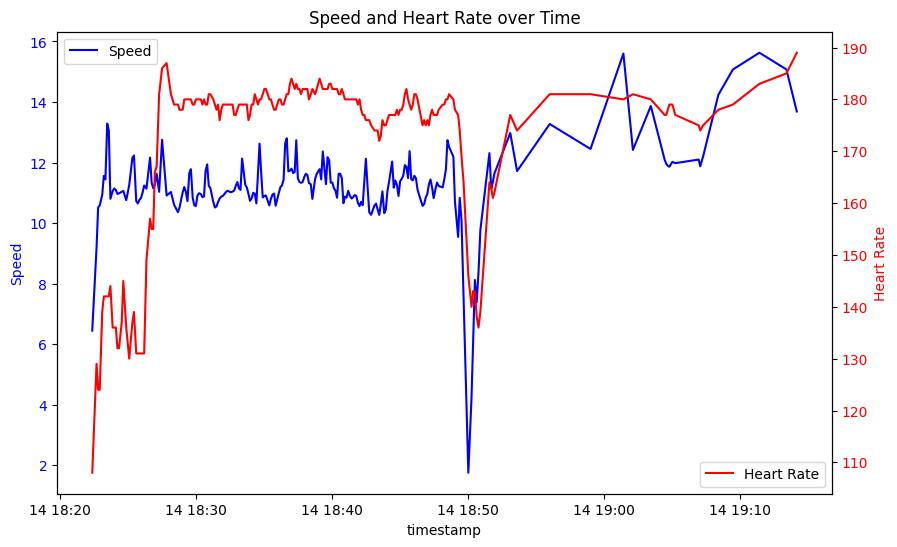

In [15]:

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=filtered_df, x='timestamp', y='speed', ax=ax1, label='Speed', color='blue')
ax1.set_ylabel('Speed', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(data=filtered_df, x='timestamp', y='heart_rate', ax=ax2, label='Heart Rate', color='red')
ax2.set_ylabel('Heart Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and show the plot
plt.title('Speed and Heart Rate over Time')
plt.show()

## Example workout heart rate vs speed pattern along the time span of workout for all sports to get a sense of overall workout performance

In [16]:

def plot_sport_data(sport, df, ax1, ax2):
    ax2 = plt.gca() 
    filtered_df = df[df['sport'] == sport]
    
    if filtered_df.empty:
        return
    
    first_row = filtered_df.iloc[0]
    
    # Create a new dataframe from the first row
    new_df = pd.DataFrame([first_row])
    new_df = new_df[['timestamp', 'heart_rate', 'speed']]
    
    # Explode the dataframe
    exploded_df = new_df.explode('timestamp').reset_index(drop=True)
    exploded_df['heart_rate'] = new_df['heart_rate'].explode().reset_index(drop=True)
    exploded_df['speed'] = new_df['speed'].explode().reset_index(drop=True)
    exploded_df['timestamp'] = pd.to_datetime(exploded_df['timestamp'], unit='s')
    exploded_df['time_diff'] = exploded_df['timestamp'].diff().dt.total_seconds()

    time_diff_threshold = 20
    # guarentee the resulted df has at least 100 rows
    while True:
        filtered_df = exploded_df[(exploded_df['time_diff'] >= time_diff_threshold) | (exploded_df['time_diff'].isna())]
        if len(filtered_df) >= 100 or time_diff_threshold <= 0:
            break
        time_diff_threshold -= 1

    filtered_df = filtered_df.drop(columns=['time_diff'])

    sns.lineplot(data=filtered_df, x='timestamp', y='speed', ax=ax1, label='Speed', color='blue')
    ax1.set_ylabel('Speed', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(['Speed'], loc='upper left')

    # ax2 = ax1.twinx()
    sns.lineplot(data=filtered_df, x='timestamp', y='heart_rate', ax=ax2, label='Heart Rate', color='red')
    ax2.set_ylabel('Heart Rate', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(['Heart Rate'], loc='upper right')
    ax1.set_title(sport)

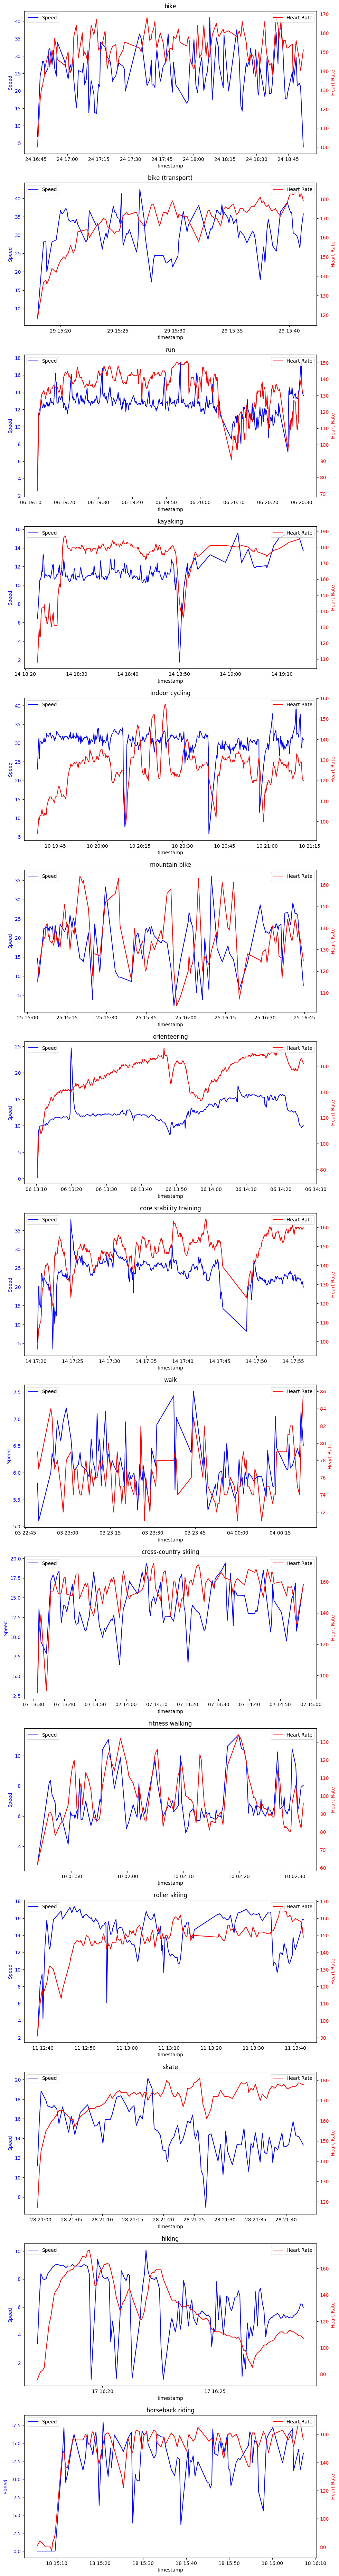

In [17]:
# Create subplots with 1 column and a number of rows equal to the number of sports
fig, axes = plt.subplots(nrows=len(sport_types), ncols=1, figsize=(10, 5 * len(sport_types)))  # Adjusted figsize for better layout
fig.tight_layout(pad=4.0)

for i, sport in enumerate(sport_types):
    plot_sport_data(sport, df, axes[i], axes[i].twinx())

plt.show()